In [3]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [15]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
import submodules.data_filter as _df
import diffusion_pipline.data_processing as dproc
import diffusion_pipline.model as md
import submodules.cleaned_file_parser as cfp
import submodules.rs_rotation_index as rri
import submodules.robomath_addon as rma


In [5]:
# observation and action dimensions corrsponding to
# the output of PushTEnv
# obs_dim = 25
# action_dim = 13
type = '3BODY_NoNAN_16_markers'
obs_dim = 66
action_dim = 18
# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
target_fps = 120.0

action_item = ['battery', 'chisel', 'gripper']
obs_item = None

# create network object
noise_pred_net = md.ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 6.713090e+07


In [6]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/raj/diffusion_policy_cam/no-sync/turn_table_chisel/tilt_25/dataset_aug_12/train_traj/"

# Load data
dict_of_df_rigid = {}
dict_of_df_marker = {}


for file in os.listdir(base_path):
    if file.endswith(".csv"):
        # print(file)
        path_name = base_path + file
        data = cfp.DataParser.from_quat_file(file_path = path_name, target_fps=target_fps, filter=False, window_size=15, polyorder=3)
        marker_data = data.get_marker_Txyz()
        data_state_dict = data.get_rigid_TxyzRxyz()

        dicts = [data_state_dict, marker_data]
        trimmed_dicts = _df.trim_lists_in_dicts(dicts)

        
        dict_of_df_rigid[file] = trimmed_dicts[0]
        dict_of_df_marker[file] = trimmed_dicts[1]

item_name = data.rigid_bodies
marker_name = data.markers

if len(dict_of_df_rigid) == len(dict_of_df_marker):

    rigiddataset, index = _df.episode_combiner(dict_of_df_rigid, item_name)
    markerdataset, _ = _df.episode_combiner(dict_of_df_marker, marker_name)
    print(index[action_item[0]])


#### if you don't want battery info then just do obs_item = None abd also do clear all outputs and restart the kernal before that and satrt from the top 

dataset = dproc.TaskStateDataset(Rigiddataset=rigiddataset, Velocitydataset = None, Markerdataset= markerdataset, index= index[action_item[0]], 
                                 action_item = action_item, obs_item = obs_item,
                                 marker_item= marker_name,
                                 pred_horizon=pred_horizon,
                                 obs_horizon=obs_horizon,
                                 action_horizon=action_horizon)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

[1548, 2505, 4323, 5491, 6944, 8259, 10093, 12199, 13801, 15523, 17024, 18665, 19945, 21762, 23595, 25204, 26911, 28507, 29936, 31726, 33055, 34618, 36013, 37416, 38718, 40392, 42111, 43623, 45143, 46917, 48847, 50468, 51874, 53808, 55556, 56955, 58498, 59809, 61178, 62654, 64309, 65798, 67345, 68688, 69869, 71169, 72543, 74347, 76163, 77551, 79193, 80737, 82347, 83898, 85579, 87068, 88149, 89890, 91333, 93308, 94952, 97212, 98914, 100772, 102262, 103700, 105693, 107286, 109083, 111531, 113519, 115527, 117539, 118683, 120486, 122332, 124182, 125762, 127379, 129116, 130493, 131768, 133407, 134898, 136434, 138137, 140243, 141659, 143042, 144436, 145800, 147443, 149242, 150901, 152979, 154942, 156730, 158218, 160012, 161379, 163308, 164858, 166248, 167519, 168871, 170442, 171801, 173545, 175316, 176698, 178174, 180089, 182046, 183748, 185687, 187592, 189630, 191646, 192992, 194791, 195950, 197425, 199034, 200625, 202444, 204347, 206540, 208510, 210461, 212164, 213577, 215177, 217000, 2187

In [7]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs =400
checkpoint_dir = '/home/cam/Documents/raj/diffusion_policy_cam/no-sync/checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_interval = 3600
last_checkpoint_time = time.time()
# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    epoch_loss = []
    batch_loss_per_epoch = []

    for epoch_idx in tglobal:
        batch_loss = []
        batch_noise = []
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:

            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs']
                naction = nbatch['action']
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1).float().to(device)
                # print(obs_cond.type())

                # sample noise to add to actions
                # noise = torch.randn(naction.shape, device=device)
                noise = torch.randn(naction.shape)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,)
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)
                
                noise = noise.to(device)
                
                timesteps = timesteps.to(device)

                # print(noisy_actions.type())
                noisy_actions = noisy_actions.type(torch.FloatTensor).to(device)
                # print(noisy_actions.type())

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)
                
                batch_noise.append(noise_pred)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net)
                # print(ema.state_dict)

                # logging
                loss_cpu = loss.item()
                batch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # save checkpoint
        # went to the emma model library and added state_dict to the model
        current_time = time.time()
        if current_time - last_checkpoint_time > checkpoint_interval:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{type}_epoch_{epoch_idx}.pth')
            torch.save({
                        'epoch': epoch_idx,
                        'model_state_dict': noise_pred_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': lr_scheduler.state_dict(),
                        'ema_state_dict': ema.state_dict(),
                        'len_dataloader': len(dataloader),
                        'dataset_stats': dataset.stats,
                        'num_epochs': num_epochs,
                        'obs_dim': obs_dim,
                        'action_dim': action_dim,
                        'pred_horizon': pred_horizon,
                        'obs_horizon': obs_horizon,
                        'action_horizon': action_horizon,
                        'target_fps': target_fps,
                        'action_item': action_item,
                        'obs_item': obs_item,
                        'marker_item': marker_name,
                        'num_diffusion_iters': num_diffusion_iters,
                    }, checkpoint_path)
            last_checkpoint_time = current_time
            
        tglobal.set_postfix(loss=np.mean(batch_loss))
        epoch_loss.append(np.mean(batch_loss))
        batch_loss_per_epoch.append(batch_loss)

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net

checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{type}_epoch_{epoch_idx}.pth')
torch.save({
    'epoch': epoch_idx,
    'model_state_dict': noise_pred_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'ema_state_dict': ema.state_dict(),
    'len_dataloader': len(dataloader),
    'dataset_stats': dataset.stats,
    'num_epochs': num_epochs,
    'obs_dim': obs_dim,
    'action_dim': action_dim,
    'pred_horizon': pred_horizon,
    'obs_horizon': obs_horizon,
    'action_horizon': action_horizon,
    'target_fps': target_fps,
    'action_item': action_item,
    'obs_item': obs_item,
    'marker_item': marker_name,
    'num_diffusion_iters': num_diffusion_iters,
}, checkpoint_path)
print(f'Checkpoint saved at epoch {epoch_idx}')

Epoch: 100%|██████████| 400/400 [8:20:04<00:00, 75.01s/it, loss=0.000261]  


Checkpoint saved at epoch 399


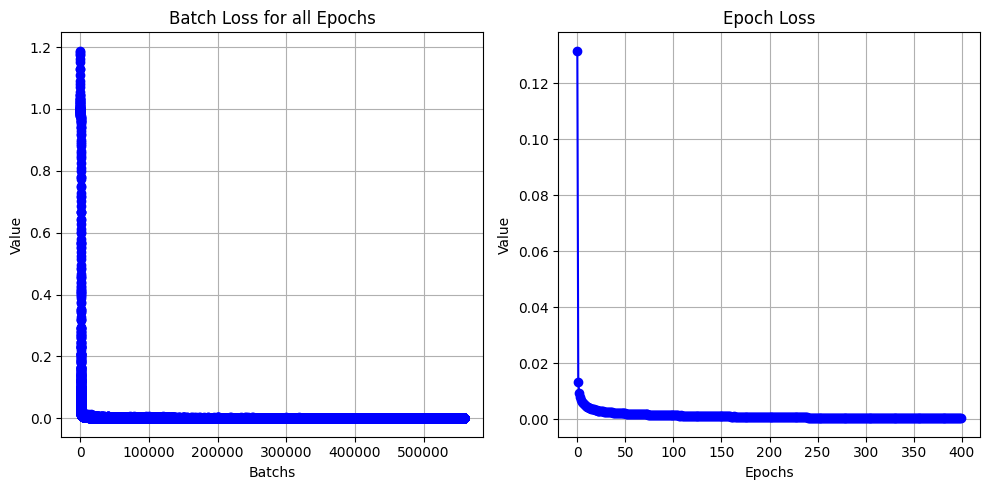

In [9]:
# Create a figure and axis
import matplotlib.pyplot as plt

flatten_loss = np.array(batch_loss_per_epoch)

flatten_loss = flatten_loss.flatten()
# Define subplots correctly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for the first subplot (ax1)
ax1.plot(flatten_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the first subplot (ax1)
ax1.set_xlabel('Batchs')
ax1.set_ylabel('Value')
ax1.set_title('Batch Loss for all Epochs')
ax1.grid(True)
# ax1.legend()

# Plot for the second subplot (ax2)
ax2.plot(epoch_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the second subplot (ax2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')
ax2.set_title('Epoch Loss')
ax2.grid(True)
# ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

####  Testing Evaluation

In [10]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/raj/diffusion_policy_cam/no-sync/turn_table_chisel/tilt_25/dataset_aug_12/test_traj/"

# Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_quat_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        marker_data = data_test.get_marker_Txyz()
        data_state_dict = data_test.get_rigid_TxyzRxyz()

        dicts = [data_state_dict, marker_data]
        trimmed_dicts = _df.trim_lists_in_dicts(dicts)

        
        dict_of_df_rigid_test[file] = trimmed_dicts[0]
        dict_of_df_marker_test[file] = trimmed_dicts[1]


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)

indexes = index_test[action_item[0]]
action = []
obs = []
for i in range(indexes[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print(a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print(b)
    
    action.append(a)
    obs.append(b)
    
# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)

# Initialize lists to store segmented data
splits_obs = []
splits_action = []
previous_index = 0

# Iterate through episode_ends and slice action and obs accordingly
for index in indexes:
    splits_obs.append(obs[previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(action[previous_index:index + 1])
    previous_index = index + 1

In [11]:
len(splits_obs[0][0])

66

In [ ]:
B0_T_mb0 = rma.BxyzRxyz_wrt_AxyzRxyz(W_TxyzRxyz_mb0, W_TxyzRxyz_B0) # Rigid Body position wrt Battery at time 0
B_T_mb = B0_T_mb0 # Marker position wrt Battery at time t is considered same as time 0 as the marker is rigidly attached to the battery
W_T_B = rm.TxyzRxyz_2_Pose(W_TxyzRxyz_Bt)

In [23]:

import collections

trajectories = {}
losses_per_traj = {}
for j in range(len(indexes)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    new_obs = []
    # max_steps = len(test_data['action'])
    battery_start = splits_action[j][0][:6]
    markers_start = [obs[i:i + 3] for i in range(18, len(obs), 3)]
    max_steps = len(actions_test)
    # max_steps = 2400
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            # print(len(naction[0]))
            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # traj.extend(action)
            losses = []
            for i in range(len(action)):
                # loss
                # print("Action_pred -",action[0])
                # print("Action_orignal -",actions_test[0])
                # print("Obs_added without pred-",com_obs[i])
                com_obs_part = []
            
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                
                action_last = list(action[i])
                # print("Action_last ---",action_last)

                battery_action_T = action_last[:6]
                chisel_action_T = action_last[6:12]
                # print("chisel_action_T -",chisel_action_T)
                
                # distance = _df.distance(np.array(chisel_action_T), np.array(battery_action_T))
                
                chisel_actin_wrt_battery = rma.BxyzRxyz_wrt_AxyzRxyz(chisel_action_T, battery_action_T)
                # print("Chisel_actin_wrt_battery -",chisel_actin_wrt_battery)
                chisel_XYZ  = chisel_actin_wrt_battery[:3]
                distance = np.sqrt((chisel_XYZ[0])**2 + (chisel_XYZ[1])**2 + (chisel_XYZ[2])**2)
                # print("Distance -",distance)
                
                # Concatenating prediction to the obs lists
                if distance < 430:
                    for marker0 in markers_start:
                        com_obs_part.extend(rri.calculate_new_marker_pos(marker0, battery_start, battery_action_T))
                        
                else:
                    
                    com_obs_part = list(com_obs[i][18:])
                # print("Obs to add", com_obs_part)
                # new_obs.append(action_last + com_obs_part)
                # print("Obs_added with pred -",com_obs[i])
                # obs_deque.append(new_obs[i])
                obs_deque.append(action_last + com_obs_part)
                
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                traj.append(action_last + com_obs_part)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
            # com_obs = com_obs[1:]
            # actions_test = actions_test[1:]
            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories[f"{name[j]}"] = traj

Eval:   0%|          | 0/1753 [00:00<?, ?it/s]

Eval:  96%|█████████▌| 1560/1630 [01:21<00:03, 18.79it/s, loss=2.42e+3]

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('/home/cam/Documents/diffusion_policy_cam/no_sync/pred_comparison_july_22/pred_correct_method_velocity_chisel_gripper_battery/pred_trajectory_chisel_plots.pdf') as pdf:
    for index, key in enumerate(trajectories.keys()):

        # if index == 1:
        #     break

        x_coords = [item[3] for item in trajectories[key]]
        y_coords = [item[4] for item in trajectories[key]]
        z_coords = [item[5] for item in trajectories[key]]
        # on_off = [item[12] for item in trajectories[key]]

        fig = plt.figure(figsize=(18, 24),constrained_layout=True)
        
        # Add a global title for the figure
        # fig.suptitle(f'Comprehensive Plots for {result_dict[index]['Path'].split('/')[-1]}', fontsize=16, fontweight='bold')
        fig.suptitle(f'Comprehensive Plots for {key} - loss = {losses_per_traj[key]}', fontsize=16, fontweight='bold',y=0.91)
        # plt.subplots_adjust(top=0.9, hspace=0.4)

        # Plot XYZ coordinates
        plt.subplot(4, 2, 1)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Euler angles
        roll = [item[0] for item in trajectories[key]]
        pitch = [item[1] for item in trajectories[key]]
        yaw = [item[2] for item in trajectories[key]]

        plt.subplot(4, 2, 2)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities (Radians)')


        x_coords = [item[3] for item in splits_action[index]]
        y_coords = [item[4] for item in splits_action[index]]
        z_coords = [item[5] for item in splits_action[index]]
        # on_off = [item[12] for item in splits_action[index]]


        # Plot XYZ coordinates
        plt.subplot(4, 2, 3)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[0] for item in splits_action[index]]
        pitch = [item[1] for item in splits_action[index]]
        yaw = [item[2] for item in splits_action[index]]

        plt.subplot(4, 2, 4)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        x_coords = [item[9] for item in trajectories[key]]
        y_coords = [item[10] for item in trajectories[key]]
        z_coords = [item[11] for item in trajectories[key]]

        # Plot Euler vel
        plt.subplot(4, 2, 5)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in trajectories[key]]
        pitch = [item[7] for item in trajectories[key]]
        yaw = [item[8] for item in trajectories[key]]

        plt.subplot(4, 2, 6)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities ')


        x_coords = [item[9] for item in splits_action[index]]
        y_coords = [item[10] for item in splits_action[index]]
        z_coords = [item[11] for item in splits_action[index]]

        # Plot Euler vel
        plt.subplot(4, 2, 7)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in splits_action[index]]
        pitch = [item[7] for item in splits_action[index]]
        yaw = [item[8] for item in splits_action[index]]

        plt.subplot(4, 2, 8)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        plt.tight_layout()
        pdf.savefig(fig)  # Save the figure with the global title
        plt.close(fig)
    # plt.show()

In [22]:
import csv


for index, key in enumerate(trajectories.keys()):
    print(index)
    # Define the file path or name
    file_path = f'/home/cam/Documents/raj/diffusion_policy_cam/no-sync/turn_table_chisel/tilt_25/dataset_aug_12/pred_test/pred_{key}'

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']},
        'Vel': {'len':6,
                    'dof': ['Xv', 'Yv', 'Zv', 'xv', 'yv', 'zv']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params[save_type]['dof']]
    # _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _mk_col_names
        # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(trajectories[key])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [23]:
import csv


for index, key in enumerate(trajectories.keys()):
    print(index)
    # Define the file path or name
    file_path = f'/home/cam/Documents/raj/diffusion_policy_cam/no-sync/turn_table_chisel/tilt_25/dataset_Aug_6/2400_time_steps/csvs/pred_{key}'

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']},
        'Vel': {'len':6,
                    'dof': ['Xv', 'Yv', 'Zv', 'xv', 'yv', 'zv']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params[save_type]['dof']]
    # _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _mk_col_names
    print(len(trajectories[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[len(x):]])  for x, y in zip(np.array(trajectories[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)

0
2408
1233
1
2408
1129
2
2408
1255
3
2408
1166
4
2408
1105
5
2408
1218
6
2408
1189
7
2408
1156
8
2408
1190
9
2408
1111
10
2408
1291
11
2408
1174
12
2408
1300
13
2408
1120
14
2408
1201
15
2408
1266
16
2408
1154
17
2408
1182
18
2408
1290
19
2408
1188
20
2408
1070
21
2408
1138


#### Training Data Evaluation

In [ ]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/diffusion_policy_cam/no_sync/data_chisel_task/cleaned_test_traj/"

## Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        marker_data = data_test.get_marker_Txyz()
        data_state_dict = data_test.get_rigid_TxyzRxyz()

        dicts = [data_state_dict, marker_data]
        trimmed_dicts = _df.trim_lists_in_dicts(dicts)

        
        dict_of_df_rigid_test[file] = trimmed_dicts[0]
        dict_of_df_marker_test[file] = trimmed_dicts[1]


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)

indexes = index_test[action_item[0]]
action = []
obs = []
for i in range(indexes[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print(a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [rigiddataset_test[item][i] for item in obs_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print(b)
    
    action.append(a)
    obs.append(b)
    
# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)

# Initialize lists to store segmented data
splits_obs = []
splits_action = []
previous_index = 0

# Iterate through episode_ends and slice action and obs accordingly
for index in indexes:
    splits_obs.append(obs[previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(action[previous_index:index + 1])
    previous_index = index + 1

In [ ]:
trajectories_normal = {}
losses_per_traj = {}
for j in range(len(indexes)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # print(action[0])
            # print(actions_test[0])
            traj.extend(action)
            losses = []

            # if len(action) <= len(actions_test):
            #     lenths = len(action)

            # else :
            #     lenths = len(actions_test)
                
            for i in range(len(action)):
                # loss
                # print("Action_pred -",action[i])
                # print("Action_orignal -",actions_test[i])
                # print("Obs_added -",com_obs[i])
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories_normal[f"{name[j]}"] = traj

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('/home/cam/Documents/diffusion_policy_cam/no_sync/pred_comparison_july_22/pred_incorrect_method_velocity_chisel_gripper_battery/pred_trajectory_chisel_plots.pdf') as pdf:
    for index, key in enumerate(trajectories_normal.keys()):

        # if index == 1:
        #     break

        x_coords = [item[3] for item in trajectories_normal[key]]
        y_coords = [item[4] for item in trajectories_normal[key]]
        z_coords = [item[5] for item in trajectories_normal[key]]
        # on_off = [item[12] for item in trajectories_normal[key]]

        fig = plt.figure(figsize=(18, 24),constrained_layout=True)
        
        # Add a global title for the figure
        # fig.suptitle(f'Comprehensive Plots for {result_dict[index]['Path'].split('/')[-1]}', fontsize=16, fontweight='bold')
        fig.suptitle(f'Comprehensive Plots for {key} - loss = {losses_per_traj[key]}', fontsize=16, fontweight='bold',y=0.91)
        # plt.subplots_adjust(top=0.9, hspace=0.4)

        # Plot XYZ coordinates
        plt.subplot(4, 2, 1)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Euler angles
        roll = [item[0] for item in trajectories_normal[key]]
        pitch = [item[1] for item in trajectories_normal[key]]
        yaw = [item[2] for item in trajectories_normal[key]]

        plt.subplot(4, 2, 2)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities (Radians)')


        x_coords = [item[3] for item in splits_action[index]]
        y_coords = [item[4] for item in splits_action[index]]
        z_coords = [item[5] for item in splits_action[index]]
        # on_off = [item[12] for item in splits_action[index]]


        # Plot XYZ coordinates
        plt.subplot(4, 2, 3)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[0] for item in splits_action[index]]
        pitch = [item[1] for item in splits_action[index]]
        yaw = [item[2] for item in splits_action[index]]

        plt.subplot(4, 2, 4)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        x_coords = [item[9] for item in trajectories_normal[key]]
        y_coords = [item[10] for item in trajectories_normal[key]]
        z_coords = [item[11] for item in trajectories_normal[key]]

        # Plot Euler vel
        plt.subplot(4, 2, 5)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in trajectories_normal[key]]
        pitch = [item[7] for item in trajectories_normal[key]]
        yaw = [item[8] for item in trajectories_normal[key]]

        plt.subplot(4, 2, 6)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities ')


        x_coords = [item[9] for item in splits_action[index]]
        y_coords = [item[10] for item in splits_action[index]]
        z_coords = [item[11] for item in splits_action[index]]

        # Plot Euler vel
        plt.subplot(4, 2, 7)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in splits_action[index]]
        pitch = [item[7] for item in splits_action[index]]
        yaw = [item[8] for item in splits_action[index]]

        plt.subplot(4, 2, 8)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        plt.tight_layout()
        pdf.savefig(fig)  # Save the figure with the global title
        plt.close(fig)
    # plt.show()

In [ ]:
import csv


for index, key in enumerate(trajectories_normal.keys()):
    print(index)
    # Define the file path or name
    file_path = f'/home/cam/Documents/diffusion_policy_cam/no_sync/pred_comparison_july_22/pred_incorrect_method_velocity_chisel_gripper_battery/pred_{key}'

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']},
        'Vel': {'len':6,
                    'dof': ['Xv', 'Yv', 'Zv', 'xv', 'yv', 'zv']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params['Vel']['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    print(len(trajectories_normal[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories_normal[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[12:]])  for x, y in zip(np.array(trajectories_normal[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)